Using device: cuda
Classes: ['Tomato__Bacterial_spot', 'Tomato__Early_blight', 'Tomato__Late_blight', 'Tomato__Leaf_Mold', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites Two-spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato__healthy']
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/guest/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/home/guest/anvitha_env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/guest/anvitha_env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 114MB/s]


Epoch 1/10, Train Loss: 1.9725, Val Acc: 0.4744
Epoch 2/10, Train Loss: 1.3419, Val Acc: 0.5385
Epoch 3/10, Train Loss: 1.1076, Val Acc: 0.5321
Epoch 4/10, Train Loss: 0.9233, Val Acc: 0.6346
Epoch 5/10, Train Loss: 0.8003, Val Acc: 0.5962
Epoch 6/10, Train Loss: 0.7189, Val Acc: 0.5577
Epoch 7/10, Train Loss: 0.6829, Val Acc: 0.6346
Epoch 8/10, Train Loss: 0.6518, Val Acc: 0.6410
Epoch 9/10, Train Loss: 0.6425, Val Acc: 0.6346
Epoch 10/10, Train Loss: 0.6353, Val Acc: 0.6731
Model saved to models/tomato_resnet18.pth


FileNotFoundError: [Errno 2] No such file or directory: '../outputs/training_plot.png'

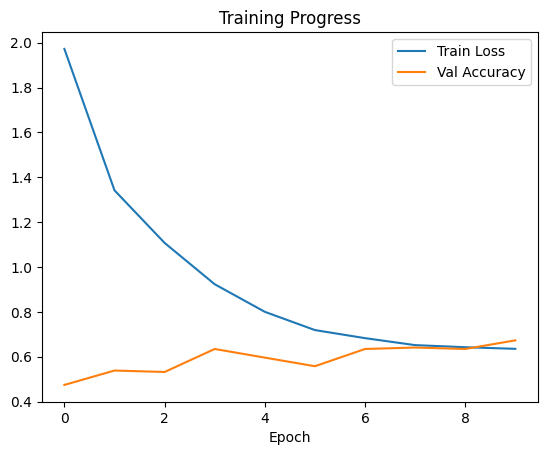

In [3]:
# notebooks/1_train_classifier.ipynb (content as Python script)

# Step 1: Imports
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Step 2: Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 3: Paths
data_dir = '../data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Step 4: Transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Step 5: Load datasets
datasets_train = datasets.ImageFolder(train_dir, transform=train_transforms)
datasets_val = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = DataLoader(datasets_train, batch_size=16, shuffle=True)
val_loader = DataLoader(datasets_val, batch_size=16, shuffle=False)

class_names = datasets_train.classes
print("Classes:", class_names)

# Step 6: Load model
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False  # Freeze backbone
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Step 7: Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Step 8: Training loop
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

# Step 9: Save model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), '../models/tomato_resnet18.pth')
print("Model saved to models/tomato_resnet18.pth")

# Step 10: Plot training history
plt.plot(train_losses, label='Train Loss')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.title('Training Progress')
plt.savefig("../outputs/training_plot.png")
plt.show()


In [2]:
!pip install seaborn

  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [seaborn]m3/4 [seaborn]
